In [ ]:
!unzip -q train.zip

In [ ]:
import numpy as np
import pandas as pd
import numpy as np 
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve, roc_curve, roc_auc_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
import numpy as np 
import lightgbm as lg
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
plt.style.use('seaborn')
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [ ]:
data_path = '/content/'
labels = pd.read_csv(data_path+'labels_train.csv', header=None)
gsr_train = pd.read_csv(data_path+'gsr_train.csv', header=None)
rr_train = pd.read_csv(data_path+'rr_train.csv', header=None)
temp_train = pd.read_csv(data_path+'temp_train.csv', header=None)
hr_train = pd.read_csv(data_path+'hr_train.csv', header=None)


In [ ]:
df = pd.concat([rr_train, hr_train, temp_train, gsr_train], axis=0, sort=False)

In [ ]:
data_orig = pd.concat([rr_train, hr_train, temp_train, gsr_train], axis=1, sort=False)

In [ ]:
def fe(df,num):
    '''
    feature engineering step
    '''
    df.columns = [str(num)+'_'+str(i) for i in range(30)]
    df[f'x_{num}_min'] = df.min(1)
    df[f'x_{num}_max'] = df.max(1)
    df[f'x_{num}_med'] = df.median(1)
    df[f'x_{num}_std'] = df.std(1)
    df[f'x_{num}_sum'] = df.sum(1)
    df[f'x_{num}_ske'] = df.skew(1)
    df[f'x_{num}_mea'] = df.mean(1)

    
for nnn, i_df in enumerate([gsr_train, rr_train, temp_train, hr_train]):#temp_train
    i_df = fe(i_df, nnn)

In [ ]:
data_fe = pd.concat([rr_train, gsr_train, temp_train, hr_train], axis=1, sort=False)
data_fe_only = data_fe[[i for i in data_fe.columns if 'x'==str(i)[:1]]]
data_norm = (data_fe_only - data_fe_only.mean())/data_fe_only.std()

In [ ]:
class EnsembleModel():
    def __init__(self, n_models=6, num_boost_round=20):
        self.lg_models = {}
        self.n_models = n_models
        self.num_boost_round = num_boost_round
    def fit(self, X, y):
        params = {}
        
        params[0] = {'num_leaves': 216,
                     'max_bin': 398,
                     'colsample_bytree': '0.730',
                     'learning_rate': '0.270',
                     'lambda_l2': 55,
                     'objective': 'binary'}
        params[1] = {'num_leaves': 176,
                     'max_bin': 413,
                     'colsample_bytree': '0.730',
                     'learning_rate': '0.280',
                     'lambda_l2': 56,
                     'objective': 'binary'}
        params[2] = {'num_leaves': 362,
                     'max_bin': 438,
                     'colsample_bytree': '0.550',
                     'learning_rate': '0.220',
                     'lambda_l2': 69,
                     'objective': 'binary'}
        params[3] = {'num_leaves': 544,
                     'max_bin': 22,
                     'colsample_bytree': '0.320',
                     'learning_rate': '0.220', 'lambda_l2': 76, 'objective': 'binary'}
        params[4] = {'num_leaves': 366,
                     'max_bin': 218,
                     'colsample_bytree': '0.400',
                     'learning_rate': '0.180', 'lambda_l2': 86, 'objective': 'binary'}
        
        params[5] = {'num_leaves': 123, 'max_bin': 442,
                     'colsample_bytree': '0.410', 'learning_rate': '0.500',
                     'lambda_l2': 87, 'objective': 'binary'}
        
        params[6] = {'num_leaves': 246, 'max_bin': 316,
                     'colsample_bytree': '0.670', 'learning_rate': '0.450',
                     'lambda_l2': 138, 'objective': 'binary'}



        #y_hat_lg = np.zeros((X_test.shape[0],self.n_models))
        train_data = lg.Dataset(X, y)
        for i in range(self.n_models):
            self.lg_models[i] = lg.train(params[i], train_data, num_boost_round=self.num_boost_round)

    def predict_proba(self, X):
        #print(X.shape)
        y_hat_xgb_test = np.zeros((X.shape[0],self.n_models+1))
        for num in range(self.n_models+1):
            if num < self.n_models:
                y_hat_xgb_test[:,num] = self.lg_models[num].predict(X).reshape(-1)

        return np.mean(y_hat_xgb_test,1)

In [ ]:
def get_scores(model, X, y, lg=False):
    X = np.array(X)
    y = np.array(y)
    
    cv = StratifiedKFold(5, random_state=45, shuffle=True)
    spl = cv.split(X, y)
    
    results_acc = []
    results_auc = []
    for train_index, test_index in spl:
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        
        if not lg: 
            y_hat = model.predict_proba(X_test)[:,1]
        else:
            y_hat = model.predict_proba(X_test)
            
        results_auc.append(roc_auc_score(y_test, y_hat))
        results_acc.append(accuracy_score(y_test, np.round(y_hat)))
    #########################################################
    cv = StratifiedKFold(4, random_state=1990, shuffle=True)
    spl = cv.split(X, y)
    for train_index, test_index in spl:
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        if not lg: 
            y_hat = model.predict_proba(X_test)[:,1]
        else:
            y_hat = model.predict_proba(X_test)

        results_auc.append(roc_auc_score(y_test, y_hat))
        results_acc.append(accuracy_score(y_test, np.round(y_hat)))
    print('ACC:', np.mean(results_acc), np.std(results_acc))
    print('AUC:', np.mean(results_auc), np.std(results_auc))
    print('\n')
    return np.mean(results_acc), np.std(results_acc), np.mean(results_auc), np.std(results_auc)


def tr_(x):
    x[x>0.5] = 1
    x[x<0.51] = 0
    return x

In [ ]:
model = EnsembleModel(n_models=7, num_boost_round=55)
get_scores(model, data_norm.values, labels[0].values, lg=True)

ACC: 0.6251808186423955 0.04141525744843811
AUC: 0.6847766215039268 0.03890341258197547




(0.6251808186423955,
 0.04141525744843811,
 0.6847766215039268,
 0.03890341258197547)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_norm.values, labels[0].values, stratify=labels[0].values,random_state=42,test_size = 0.2)
clf = MLPClassifier(random_state=42, max_iter = 300, hidden_layer_sizes = 2, learning_rate = 'adaptive', alpha= 0.001).fit(X_train, y_train)
print(clf.score(X_test, y_test))
print(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
from sklearn.metrics import classification_report
print(classification_report(y_test, clf.predict(X_test)))

0.6771653543307087
0.6581101190476191
              precision    recall  f1-score   support

           0       0.67      0.70      0.68        63
           1       0.69      0.66      0.67        64

    accuracy                           0.68       127
   macro avg       0.68      0.68      0.68       127
weighted avg       0.68      0.68      0.68       127



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [ ]:

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)
print(neigh.score(X_test, y_test))
print(roc_auc_score(y_test, neigh.predict_proba(X_test)[:, 1]))
from sklearn.metrics import classification_report
print(classification_report(y_test, neigh.predict(X_test)))

0.5826771653543307
0.6333085317460319
              precision    recall  f1-score   support

           0       0.58      0.60      0.59        63
           1       0.59      0.56      0.58        64

    accuracy                           0.58       127
   macro avg       0.58      0.58      0.58       127
weighted avg       0.58      0.58      0.58       127



In [ ]:

svc = make_pipeline(StandardScaler(), SVC(gamma='auto',probability=True))
svc.fit(X_train, y_train)
print(svc.score(X_test, y_test))
print(roc_auc_score(y_test, svc.predict(X_test)))
from sklearn.metrics import classification_report
print(classification_report(y_test, svc.predict(X_test)))

0.6456692913385826
0.6457093253968254
              precision    recall  f1-score   support

           0       0.64      0.65      0.65        63
           1       0.65      0.64      0.65        64

    accuracy                           0.65       127
   macro avg       0.65      0.65      0.65       127
weighted avg       0.65      0.65      0.65       127



In [ ]:

gnb = GaussianNB()
gnb.fit(X_train, y_train)
print(gnb.score(X_test, y_test))
print(roc_auc_score(y_test, gnb.predict_proba(X_test)[:, 1]))
from sklearn.metrics import classification_report
print(classification_report(y_test, gnb.predict(X_test)))

0.6377952755905512
0.7291666666666666
              precision    recall  f1-score   support

           0       0.59      0.89      0.71        63
           1       0.78      0.39      0.52        64

    accuracy                           0.64       127
   macro avg       0.69      0.64      0.61       127
weighted avg       0.69      0.64      0.61       127



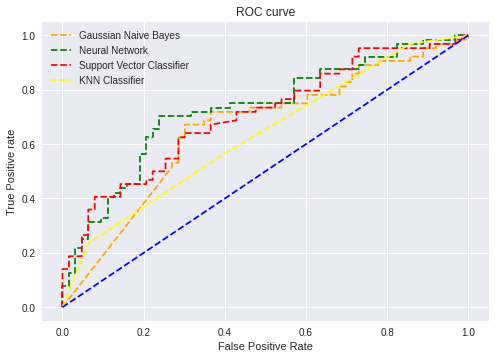

In [ ]:


nn = clf.predict_proba(X_test)
nb = gnb.predict_proba(X_test)
svm = svc.predict_proba(X_test)
knn = neigh.predict_proba(X_test)

fpr1, tpr1, thresh1 = roc_curve(y_test, nn[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, nb[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, svm[:,1], pos_label=1)
fpr4, tpr4, thresh4 = roc_curve(y_test, knn[:,1], pos_label=1)

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)


# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Gaussian Naive Bayes')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Neural Network')
plt.plot(fpr3, tpr3, linestyle='--',color='red', label='Support Vector Classifier')
plt.plot(fpr4, tpr4, linestyle='--',color='yellow', label='KNN Classifier')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC')
plt.show();